In [1]:
import numpy as np
import pandas as pd

#from PIL import Image

import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

import glob
import os
from os import listdir
from os.path import isfile, join

C:\Users\Augusto\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
#pip install tensorflow_addons

In [3]:
 print(tf.__version__)

2.9.1


In [4]:
# Checking if cuda is there.

print("Cuda Availability: ", tf.test.is_built_with_cuda())

Cuda Availability:  True


In [5]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

<h2>Load Data</h2>

In [6]:
INPUT_WIDTH = 8

In [7]:
def readcsv(args):
    return pd.read_csv(args, index_col=False)

In [8]:
df = pd.concat(map(readcsv, glob.glob("Sequences_Data" + "/*.csv")))

In [9]:
COLUMN_INDICES = {name: i for i, name in enumerate(df.columns)}
LABEL_COLUMNS = ['Production', 'Units']

In [10]:
len(df)

758

<h3>Trick to leverage all the data in the CSVs, by repeating the data by length of sequence times and then adding an offset to each of the repeated data</h3>

In [11]:
def remove_creep_tumor(df):
    delete_indexes=[]
    for i in range((len(df))-1):
        if df[i][0] == 'Creep_Tumor':
            delete_indexes.append(i)
    return np.array(np.delete(df, delete_indexes, axis=0))

In [12]:
def remove_duplicates(df):
    delete_indexes=[]
    for i in range((len(df))-1):
        if df[i][0] == df[i+1][0]:
            j=i+1
            if (j>len(df)-1):
                break
            while(df[i][0]==df[j][0]):
                df[i][1] += df[j][1]
                delete_indexes.append(j)
                j+=1
                #print(j)
                if (j>len(df)-1):
                    break
            #for i in next ones that still == df[i][0]
            #df[i][1] += df[i+1][1]
            #delete_indexes.append(i+1)
    #print(delete_indexes)
    return np.array(np.delete(df, delete_indexes, axis=0), dtype='U20')

In [13]:
#df = pd.concat(map(readcsv, glob.glob("sequences_data" + "/*.csv")))
df = np.array(df)
df = remove_creep_tumor(df)

df = remove_duplicates(df)

df_aux = df.copy()
for i in range(INPUT_WIDTH-1):
    delete_indexes = []
    for j in range(i):
        delete_indexes.append(j)
    df = np.concatenate((df, np.array(np.delete(df_aux.copy(), delete_indexes, axis=0), dtype='U20')), axis = 0, dtype='U20')

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):]

In [15]:
len(train_df)

3644

In [16]:
len(val_df)

911

<h1>Preprocessing</h1>

In [17]:
INPUT_WIDTH = 8
LABEL_WIDTH = 1
shift = 1

INPUT_SLICE = slice(0, INPUT_WIDTH)

total_window_size = INPUT_WIDTH + shift
label_start = total_window_size - LABEL_WIDTH
LABELS_SLICE = slice(label_start, None) 

BATCH_SIZE = INPUT_WIDTH + LABEL_WIDTH

In [18]:
print(INPUT_WIDTH)
print(LABEL_WIDTH)
print(INPUT_SLICE)
print(LABELS_SLICE)

8
1
slice(0, 8, None)
slice(8, None, None)


In [19]:
def split_window_test(features):             #Ignore the comments in this cell
  #print(features)
  #features = np.array(features)
  inputs = features[:, INPUT_SLICE]
  print(inputs)
  labels = features[:, LABELS_SLICE]
  print(labels)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, INPUT_WIDTH])
  labels.set_shape([None, LABEL_WIDTH])
  #print(labels)
    
  return inputs, labels

In [22]:
SLICED_DATA_PATH = listdir('Labeled_Img')
NUM_CLASSES = len(SLICED_DATA_PATH)

In [26]:
SLICED_DATA_PATH = listdir('Labeled_Img')
DATA_PATH = './Labeled_Img/'
NUM_CLASSES = len(SLICED_DATA_PATH)
IMAGES_INPUT = []

In [27]:
for label_class in SLICED_DATA_PATH:
    for image in listdir(DATA_PATH + label_class):
        IMAGES_INPUT.append(join(DATA_PATH+label_class, image))

In [38]:
def get_seq_label(file_path):
  #Those multiple comments here are due to my try, error and research to get the correct shape. It took me more than one day to do the right code.
  
  #print(file_path)
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  #print(file_path)
  one_hot = file_path[0] == SLICED_DATA_PATH

  one_hot = tf.cast(one_hot, dtype=tf.float32)
  
  #Here is when I was trying a multiple loss function, making the loss work for category, units amount and time all at once:
    
  #Must be int before it turns into float  
  #casted = int(file_path[1])
  #casted2 = int(file_path[2])
    
  # tf.stack() doesn't add to the end like concat, it puts data side by side like in the pandas dataframe. I used it for a different purpose originally

  #all_casted = tf.stack([tf.cast(casted, dtype=tf.float32), tf.cast(casted2, dtype=tf.float32)], 0)  
  #result = tf.concat([one_hot, all_casted], 0)
    
  #return result
    

    
  return one_hot

In [39]:
def split_window(features):
  #Same difficulties here, but here it'll be better if you just ignore the comments.

  #print(features)
  #features = np.array(features)
  inputs = features[INPUT_SLICE]
  labels = features[LABELS_SLICE]
  #print(labels)
  #if LABEL_COLUMNS is not None:
  #  labels = tf.stack(
  #      [labels[:, :, COLUMN_INDICES[name]] for name in LABEL_COLUMNS],
  #      axis=-1)
  #inputs = tf.reshape(inputs, [-1, 1])
  labels = labels[0]
  #labels = tf.reshape(labels, [-1, 1])
  #input = {'Producao': inputs}
  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  #inputs.set_shape([INPUT_WIDTH])
  #labels.set_shape([LABEL_WIDTH])
  
  #print(labels)
    
  return inputs, labels

In [40]:
def create_seq_dataset(data, shuf=False):
    
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.map(get_seq_label)
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)
    #No drop remainder and then the batch gets an incomplete sequence. The RNN cell doesn't accept that.
    #Batching in this part was due to group the sequences into BATCH_SIZE (sequence length) length; it's more about just grouping information rather
    #than batching itself.
    
    ds = ds.map(split_window)
    
    #if(shuf==True):
    #    ds = ds.shuffle(len(train_df))
    ds = ds.batch(8, drop_remainder=True)
    #Here the real batching happens.
    
    return ds

In [41]:
#val_df

In [42]:
#print(label)
train_ds = create_seq_dataset(train_df, shuf=True)
val_ds = create_seq_dataset(val_df)

In [44]:
for label in train_ds.take(1):
  tf.print("Label: ", label)
  #tf.print("Number: ", number)
  #for i in label:
  #  for j in i:
  #      print(j)

Label:  ([[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 1 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 1 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 1 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]], [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]])


In [114]:
for features_batch, labels_batch in train_ds:
  print(features_batch.shape)
  print(labels_batch.shape)
  break
#Shapes

(8, 8, 53)
(8, 53)


In [47]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(8, 8, 53), dtype=tf.float32, name=None), TensorSpec(shape=(8, 53), dtype=tf.float32, name=None))>

<h1>RNN Model</h1>

In [63]:
#Change input from 53 to 55 if you try the custom loss.
inputs = layers.Input(name="sequence", shape=(INPUT_WIDTH, 53), dtype='float32')

<h4>Two different approaches on trying my custom loss</h4>

In [64]:
cce = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
def mse(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return squared_difference
    #return tf.reduce_mean(squared_difference, axis=-1)

def multi_loss(y_true, y_pred):
    category = cce(y_true[:, :-2], y_pred[:, :-2])
    amount = mse(y_true[:, -2], y_pred[:, -2])
    time = mse(y_true[:, -1], y_pred[:, -1])
    mses = tf.stack([category, amount, time], 0)
    return mses

In [65]:
cce = tf.keras.losses.CategoricalCrossentropy()
def mse(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    #return squared_difference
    return tf.reduce_mean(squared_difference, axis=-1)

def multi_loss(y_true, y_pred):
    category = cce(y_true[:, :-2], y_pred[:, :-2])
    #print(category)
    amount = mse(y_true[:, -2], y_pred[:, -2])
    #print(amount)
    time = mse(y_true[:, -1], y_pred[:, -1])
    #print(time)
    mses = tf.stack([category, amount, time], 0)
    #return tf.reduce_mean(mses)
    return mses

<h4>Model</h4>

In [82]:
def create_rnn_model():
    
    x = layers.LSTM(48,  activation='tanh', stateful=False, return_sequences=False, name='LSTM_1')(inputs)
    
    
    x = layers.Dense(48, 'relu')(x)
    
    
    classes = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    #Uncomment the 3 below if you want to try the custom loss.
    #amount = layers.Dense(1, tfa.activations.mish)(x)
    #time = layers.Dense(1, tfa.activations.mish)(x)

    #output = layers.Concatenate(axis=1)([classes, amount, time])
    
    model = Model(inputs = inputs, outputs = classes)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
    
    #I tried a fancy optimizer here, but discarded the idea.
    #radam = tfa.optimizers.RectifiedAdam()
    #ranger = tfa.optimizers.Lookahead(optimizer, sync_period=6, slow_step_size=0.5)
    
    
    #Here you can change to multi_loss, as long as you edited the dataset preprocessing; but tensorflow doesn't save a custom loss function.
    #You can try it to see how metrics differ. In my case, accuracy improved but validation loss didn't. Depending on how many neurons the LSTM had,
    #the predictions improved, but now I can't remember the number exactly.
    model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=['accuracy'])
    
    return model

RectifiedAdam starts with high learning rate of default 0.001 and then decays slowly

In [83]:
rnn_model = create_rnn_model()

In [84]:
rnn_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequence (InputLayer)       [(None, 8, 53)]           0         
                                                                 
 LSTM_1 (LSTM)               (None, 48)                19584     
                                                                 
 dense_16 (Dense)            (None, 48)                2352      
                                                                 
 dense_17 (Dense)            (None, 53)                2597      
                                                                 
Total params: 24,533
Trainable params: 24,533
Non-trainable params: 0
_________________________________________________________________


In [85]:
#len(list(train_ds))

In [86]:
#EPOCHS = len(list(train_ds))*2
EPOCHS = 23

In [87]:
history = rnn_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data = val_ds,
)

Epoch 1/23
50/50 [==============================] - 2s 18ms/step - loss: 3.3269 - accuracy: 0.1725 - val_loss: 2.9329 - val_accuracy: 0.1250
Epoch 2/23
50/50 [==============================] - 0s 5ms/step - loss: 2.8045 - accuracy: 0.1825 - val_loss: 2.8186 - val_accuracy: 0.2396
Epoch 3/23
50/50 [==============================] - 0s 5ms/step - loss: 2.6401 - accuracy: 0.2125 - val_loss: 2.6777 - val_accuracy: 0.2500
Epoch 4/23
50/50 [==============================] - 0s 5ms/step - loss: 2.4591 - accuracy: 0.2500 - val_loss: 2.6316 - val_accuracy: 0.2500
Epoch 5/23
50/50 [==============================] - 0s 6ms/step - loss: 2.2898 - accuracy: 0.3125 - val_loss: 2.5786 - val_accuracy: 0.2812
Epoch 6/23
50/50 [==============================] - 0s 5ms/step - loss: 2.1209 - accuracy: 0.3350 - val_loss: 2.5257 - val_accuracy: 0.2917
Epoch 7/23
50/50 [==============================] - 0s 5ms/step - loss: 1.9563 - accuracy: 0.3850 - val_loss: 2.4529 - val_accuracy: 0.3021
Epoch 8/23
50/50 [=

In [88]:
rnn_model.save('rnn')

INFO:tensorflow:Assets written to: rnn\assets


INFO:tensorflow:Assets written to: rnn\assets


<h4>Graphs</h4>

In [89]:
import matplotlib.pylab as plt
from matplotlib.pyplot import figure

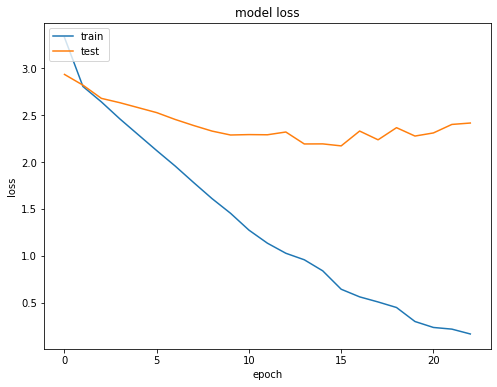

In [90]:
figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

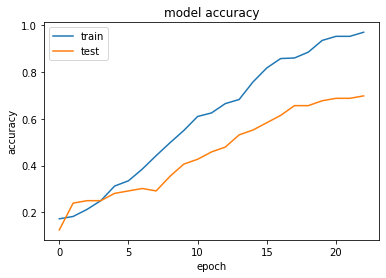

In [91]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<h2>Model Predict</h2>

In [96]:
CLASSES = listdir('Labeled_Img')

In [97]:
def create_pred_dataset(data):
    
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.map(get_seq_label)
    ds = ds.batch(BATCH_SIZE-1, drop_remainder=True)
    #Sem o drop_remainder, a sequência fica incompleta ou sem label; o que é inconcebível.
    
    #ds = ds.map(split_window)
    ds = ds.batch(1, drop_remainder=True)
    
    return ds

In [98]:
def predict_rnn(data, model):
    prediction = model.predict(data, batch_size=1)
    print(prediction)
    #pred = tf.argmax(prediction[0])
    #return CLASSES[pred]
    return prediction

In [99]:
test_data = np.array([['Hatch', '1'],
    ['Drone', '2'],
    ['Evo_Chamber', '1'],
    ['Ling', '2'],
    ['Drone', '1'],
    ['Overlord', '1'],
    ['Drone', '1'],
    ['Extractor', '1']], dtype='U20')

In [100]:
test_data = create_pred_dataset(val_df)

In [101]:
#for i in test_data.take(1):
#    print(i)

In [102]:
val_df

array([['Ling', '4', '2'],
       ['Hatch', '1', '2'],
       ['Bane_Nest', '1', '2'],
       ...,
       ['Hydra', '4', '20'],
       ['Hatch', '1', '20'],
       ['Hydra', '11', '20']], dtype='<U20')

In [103]:
prediction  = predict_rnn(test_data, rnn_model)

113/113 [==============================] - 1s 2ms/step
[[1.2066938e-15 9.1271072e-16 3.1635594e-08 ... 3.0448078e-07
  2.3050174e-14 1.9914066e-16]
 [1.2997879e-12 2.3418249e-13 4.1832678e-05 ... 2.7042739e-07
  4.9050282e-13 3.3114402e-13]
 [7.5961619e-09 2.1502169e-07 8.6676985e-01 ... 5.0165756e-08
  1.4253818e-07 1.3356004e-09]
 ...
 [7.9399997e-06 4.6601785e-09 4.3410904e-12 ... 2.8349673e-03
  9.2462775e-09 3.6311794e-02]
 [1.8266489e-04 2.3447495e-16 3.4759268e-12 ... 1.0162983e-08
  4.5292366e-16 7.1033107e-10]
 [6.0708385e-02 1.9185226e-13 4.6351581e-12 ... 5.3967757e-04
  9.3113039e-13 4.3890599e-05]]


In [109]:
#This shows the sequences we are predicting from.

count=0
for i in test_data.take(12):
    for j in i:
        #print(j)
        for k in j:
            
            #res = tf.argmax(k[:-2])  multiple loss
            res = tf.argmax(k)
            
            if(count==8):
                print()
                count=0
            #tf.print(CLASSES[res], k[-2], k[-1]) multiple loss
            tf.print(CLASSES[res])
            count+=1

Ling
Hatch
Bane_Nest
Drone
Overlord
Ling
Queen
Drone

Ling
Drone
Overlord
Bane
Evo_Chamber
Ling
Drone
Overlord

Ling
Drone
Ling
Overlord
Extractor
Missile_Attacks
Spine_Crawler
Drone

Bane
Drone
Extractor
Overlord
Drone
Roach
Lair
Drone

Ling
Bane
Extractor
Overlord
Drone
Overlord
Roach
Extractor

Overlord
Roach
Missile_Attacks
Ling
Bane
Drone
Roach
Glial_Reconstitution

Roach
Overlord
Spine_Crawler
Overlord
Roach
Ravager
Drone
Overseer

Roach
Ravager
Burrow
Queen
Drone
Roach
Hatch
Roach

Overlord
Overseer
Overlord
Hatch
Roach
Ravager
Carapace_Upgrade
Roach

Overseer
Ravager
Roach
Drone
Overlord
Drone
Hatch
Drone

Extractor
Spawning_Pool
Drone
Ling
Overlord
Queen
Drone
Metabolic_Boost

Ling
Hatch
Drone
Bane_Nest
Overlord
Drone
Ling
Overlord


In [111]:
#The predictions themselves:

for i in prediction:
    #pred = tf.argmax(i[:-2])   multiple loss
    #tf.print(CLASSES[pred], tf.cast(i[-2], dtype=tf.int32), tf.cast(i[-1], dtype=tf.int32))   multiple loss
    pred = tf.argmax(i)
    tf.print(CLASSES[pred])
    
    print()

Drone

Drone

Bane

Ling

Ling

Roach

Ravager

Overlord

Overseer

Extractor

Ling

Drone

Drone

Drone

Roach

Evo_Chamber

Overlord

Glial_Reconstitution

Overseer

Drone

Corruptor

Corruptor

Corruptor

Spawning_Pool

Hatch

Ling

Extractor

Overlord

Overlord

Overlord

Ravager

Overseer

Hydra_Den

Hydra

Carapace_Upgrade

Extractor

Overlord

Extractor

Hydra

Missile_Attacks

Hydra

Hydra

Hydra

Hatch

Drone

Ling

Bane

Ling

Ling

Extractor

Extractor

Roach

Drone

Drone

Hatch

Overseer

Ravager

Spine_Crawler

Overseer

Drone

Roach

Drone

Drone

Overlord

Overlord

Overlord

Overseer

Hydra

Overlord

Drone

Drone

Overlord

Ling

Bane

Missile_Attacks

Missile_Attacks

Drone

Drone

Overlord

Drone

Drone

Drone

Overlord

Overlord

Drone

Roach

Evo_Chamber

Roach

Roach

Corruptor

Overlord

Corruptor

Drone

Drone

Ling

Drone

Ling

Drone

Roach

Overlord

Drone

Ravager

Drone

Muta

Hydra

Overlord

Ravager

Extractor

Hydra

Overseer

Drone

Overseer

Hatch



In [106]:
for i in val_df:
    print(i)

['Ling' '4' '2']
['Hatch' '1' '2']
['Bane_Nest' '1' '2']
['Drone' '1' '2']
['Overlord' '1' '2']
['Ling' '2' '2']
['Queen' '1' '3']
['Drone' '3' '3']
['Ling' '4' '3']
['Drone' '2' '3']
['Overlord' '1' '3']
['Bane' '3' '3']
['Evo_Chamber' '1' '3']
['Ling' '2' '3']
['Drone' '4' '3']
['Overlord' '1' '3']
['Ling' '2' '3']
['Drone' '1' '3']
['Ling' '4' '3']
['Overlord' '2' '4']
['Extractor' '1' '4']
['Missile_Attacks' '1' '4']
['Spine_Crawler' '1' '4']
['Drone' '3' '4']
['Bane' '2' '4']
['Drone' '2' '4']
['Extractor' '1' '4']
['Overlord' '1' '4']
['Drone' '4' '4']
['Roach' '7' '4']
['Lair' '1' '5']
['Drone' '5' '5']
['Ling' '4' '5']
['Bane' '2' '5']
['Extractor' '1' '5']
['Overlord' '3' '5']
['Drone' '4' '5']
['Overlord' '1' '5']
['Roach' '7' '5']
['Extractor' '1' '6']
['Overlord' '1' '6']
['Roach' '6' '6']
['Missile_Attacks' '1' '6']
['Ling' '8' '6']
['Bane' '2' '6']
['Drone' '2' '6']
['Roach' '2' '6']
['Glial_Reconstitution' '1' '6']
['Roach' '3' '6']
['Overlord' '2' '6']
['Spine_Crawler' 

<h1>Ignore the Testing Zone Below</h1>

In [9]:
cnn_model = models.load_model('cnn_progress')

In [10]:
smallestW = 57
smallestH = 60
DATA_PATH = './sliced/'
LABELS = listdir(DATA_PATH)

In [11]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [smallestH, smallestW])

In [12]:
def predict_from_path(image_path):
    image = tf.io.read_file(image_path)
    image = decode_img(image)
    image = image/255.0
    image = tf.expand_dims(image, 0)
    
    
    prediction = cnn_model.predict(image)
    raw_pred = prediction
    
    #return raw_pred
    prediction = tf.argmax(prediction[0], axis=-1)
    
    return prediction

In [13]:
DATA_PATH='./img/'

In [14]:
sequence = []
sub_path = DATA_PATH+''
for i in listdir(sub_path):
    prediction = predict_from_path(sub_path+i)
    print(LABELS[prediction])
    #print(prediction)
    sequence.append(LABELS[prediction])

Extractor
Creep_Tumor
Roach_Warren
Lair
Drone
Ling
None
None
None
Extractor
Spawning_Pool
Hatch
Drone
None
None
None
None
None
Creep_Tumor
Bane_Nest
Hatch
Drone
Ling
Overlord
Metabolic_Boost
None
None
None


In [15]:
sequence = np.array(sequence)

In [63]:
desired_length = 5
num_splits = np.ceil(sequence.shape[0]/desired_length)

In [64]:
padding = int(num_splits*desired_length - sequence.shape[0])
sequence_pad = np.pad(sequence, (0,padding), 'constant', constant_values=0)

In [65]:
#sequence = np.array(sequence)
sequence_pad = sequence_pad.reshape(-1, 5)

In [78]:
sequence_pad = sequence_pad[:-1]

In [89]:
sequence_pad

array([['Extractor', 'Creep_Tumor', 'Roach_Warren', 'Lair', 'Drone'],
       ['Ling', 'None', 'None', 'None', 'Extractor'],
       ['Spawning_Pool', 'Hatch', 'Drone', 'None', 'None'],
       ['None', 'None', 'None', 'Creep_Tumor', 'Bane_Nest'],
       ['Hatch', 'Drone', 'Ling', 'Overlord', 'Metabolic_Boost']],
      dtype='<U15')

In [137]:
#sequence = sequence.reshape()

In [ ]:
tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=None, dtype="int32", padding="pre", truncating="pre", value=0.0
)

In [212]:
all_sequence

[['Extractor',
  'Creep_Tumor',
  'Roach_Warren',
  'Lair',
  'Drone',
  'Ling',
  'None',
  'None',
  'None',
  'Extractor',
  'Spawning_Pool',
  'Hatch',
  'Drone',
  'None',
  'None',
  'None',
  'None',
  'None',
  'Creep_Tumor',
  'Bane_Nest',
  'Hatch',
  'Drone',
  'Ling',
  'Overlord',
  'Metabolic_Boost',
  'None',
  'None',
  'None'],
 ['Extractor',
  'Creep_Tumor',
  'Roach_Warren',
  'Lair',
  'Drone',
  'Ling',
  'None',
  'None',
  'None',
  'Extractor',
  'Spawning_Pool',
  'Hatch',
  'Drone',
  'None',
  'None',
  'None',
  'None',
  'None',
  'Creep_Tumor',
  'Bane_Nest',
  'Hatch',
  'Drone',
  'Ling',
  'Overlord',
  'Metabolic_Boost',
  'None',
  'None',
  'None']]

<h1>Teste do Split</h1>

In [85]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [86]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Production'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Production']

In [87]:
np.array(train_df.head(6), dtype='str')

array([['Hatch', '1'],
       ['Drone', '1'],
       ['Drone', '1'],
       ['Drone', '1'],
       ['Extractor', '1'],
       ['Spawning_Pool', '1']], dtype='<U13')

In [88]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [89]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size], dtype='str'),
                           np.array(train_df[10:10+w2.total_window_size], dtype='str'),
                           np.array(train_df[20:20+w2.total_window_size], dtype='str')])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 2)
Inputs shape: (3, 6, 2)
Labels shape: (3, 1, 1)


In [90]:
example_inputs

<tf.Tensor: shape=(3, 6, 2), dtype=string, numpy=
array([[[b'Hatch', b'1'],
        [b'Drone', b'1'],
        [b'Drone', b'1'],
        [b'Drone', b'1'],
        [b'Extractor', b'1'],
        [b'Spawning_Pool', b'1']],

       [[b'Queen', b'2'],
        [b'Overlord', b'1'],
        [b'Drone', b'1'],
        [b'Hatch', b'1'],
        [b'Drone', b'1'],
        [b'Drone', b'2']],

       [[b'Drone', b'2'],
        [b'Pneumatized_Carapace', b'1'],
        [b'Creep_Tumor', b'2'],
        [b'Drone', b'3'],
        [b'Overlord', b'1'],
        [b'Drone', b'2']]], dtype=object)>

In [91]:
example_labels

<tf.Tensor: shape=(3, 1, 1), dtype=string, numpy=
array([[[b'Drone']],

       [[b'Metabolic_Boost']],

       [[b'Queen']]], dtype=object)>

<h3>Do fórum tensorflow</h3>

In [100]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, val_df=None, test_df=None,
               train_ds=train_ds,
               label_columns=None):
    # Store the raw data.
    self.train_ds = train_ds
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    
    #self.column_indices = {name: i for i, name in
    #                       enumerate(data.columns)}

    self.column_indices = column_indices
    
    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Input slices: {self.input_slice}',
        f'Label slices: {self.labels_slice}',
        f'Label column name(s): {self.label_columns}'])

In [110]:
w2 = WindowGenerator(input_width=3, label_width=1, shift=1,
                     label_columns=['Production'])
w2

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Input slices: slice(0, 3, None)
Label slices: slice(3, None, None)
Label column name(s): ['Production']

In [116]:
def split_window(self, features):
  #print(features)
  inputs = features[:, self.input_slice, :]
  #print(inputs)
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [117]:
sequence = np.array(train_df, dtype='str')

In [118]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(sequence[:w2.total_window_size]),
                           np.array(sequence[5:5+w2.total_window_size]),
                           np.array(sequence[10:10+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 4, 2)
Inputs shape: (3, 3, 2)
Labels shape: (3, 1, 1)


In [119]:
example_inputs

<tf.Tensor: shape=(3, 3, 2), dtype=string, numpy=
array([[[b'Hatch', b'1'],
        [b'Drone', b'1'],
        [b'Drone', b'1']],

       [[b'Spawning_Pool', b'1'],
        [b'Drone', b'1'],
        [b'Drone', b'1']],

       [[b'Queen', b'2'],
        [b'Overlord', b'1'],
        [b'Drone', b'1']]], dtype=object)>

In [120]:
example_labels

<tf.Tensor: shape=(3, 1, 1), dtype=string, numpy=
array([[[b'Drone']],

       [[b'Drone']],

       [[b'Hatch']]], dtype=object)>

In [103]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [105]:
@property
def train(self):
  return self.make_dataset(self.data)

def val(self):
  return self.make_dataset(self.test_df)

def test(self):
  return self.make_dataset(self.val_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [106]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

ValueError: in user code:

    C:\Users\Augusto\AppData\Local\Temp\ipykernel_15212\1500409093.py:2 split_window  *
        inputs = features[:, self.input_slice, :]
    C:\Users\Augusto\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Augusto\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\array_ops.py:1041 _slice_helper
        return strided_slice(
    C:\Users\Augusto\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Augusto\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\array_ops.py:1214 strided_slice
        op = gen_array_ops.strided_slice(
    C:\Users\Augusto\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_array_ops.py:10537 strided_slice
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\Augusto\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\Augusto\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\Augusto\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py:3561 _create_op_internal
        ret = Operation(
    C:\Users\Augusto\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\Augusto\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Index out of range using input dim 1; input has only 1 dims for '{{node strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_INT64, begin_mask=5, ellipsis_mask=0, end_mask=5, new_axis_mask=0, shrink_axis_mask=0](args_0, strided_slice/stack, strided_slice/stack_1, strided_slice/stack_2)' with input shapes: [?], [3], [3], [3] and with computed input tensors: input[3] = <1 1 1>.
